In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks

## Session 19b

## Simple RNN - Two Features
Weather Data 
- Two features

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import tensorflow as tf

from utils.helper import fn_plot_tf_hist

2024-07-20 15:11:27.929479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 15:11:27.942547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 15:11:27.946368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 15:11:27.956783: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-20 15:11:28.774921: W tensorflow/compiler/tf2

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

EPOCHS = 30  # number of cycles to run
ALPHA = 0.001  # learning rate
TEST_SIZE = 0.2 # What fraction we want to keep for testing
BATCH_SIZE = 32

# Set parameters for decoration of plots
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }
CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Helper Function

In [4]:
### Settings so that Tensorflow can not Hog all the GPU memory
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

I0000 00:00:1721468489.338948   90447 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721468489.377710   90447 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721468489.381998   90447 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Load Weather Data
Source: [Kaggle](https://www.kaggle.com/muthuj7/weather-dataset)

In [5]:
dataFilename = 'weatherHistory.csv'
data_df = pd.read_csv(os.path.join(inpDir, dataFilename))
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [6]:
data_df.shape

(96453, 12)

In [7]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], 
                                     utc=True)

In [8]:
tmp_df = data_df[['datetime', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)']]
tmp_df = tmp_df.sort_values('datetime', axis=0, ascending=True)
tmp_df = tmp_df.reset_index(drop=True)
tmp_df.head()

,datetime,Temperature (C),Humidity,Wind Speed (km/h)
0,2005-12-31 23:00:00+00:00,0.577778,0.89,17.1143
1,2006-01-01 00:00:00+00:00,1.161111,0.85,16.6152
2,2006-01-01 01:00:00+00:00,1.666667,0.82,20.2538
3,2006-01-01 02:00:00+00:00,1.711111,0.82,14.4900
4,2006-01-01 03:00:00+00:00,1.183333,0.86,13.9426


In [9]:
tmp_df = tmp_df.rename({'Temperature (C)': 'temp',
                        'Humidity': 'hum',
                        'Wind Speed (km/h)': 'wind'}, axis=1)
tmp_df.head()

,datetime,temp,hum,wind
0,2005-12-31 23:00:00+00:00,0.577778,0.89,17.1143
1,2006-01-01 00:00:00+00:00,1.161111,0.85,16.6152
2,2006-01-01 01:00:00+00:00,1.666667,0.82,20.2538
3,2006-01-01 02:00:00+00:00,1.711111,0.82,14.4900
4,2006-01-01 03:00:00+00:00,1.183333,0.86,13.9426


In [10]:
# comment uncomment following lines if you want part or full dataset

#startDate = pd.to_datetime('2007-1-1', utc=True)
#endDate = pd.to_datetime('2008-1-1', utc=True)
#temp_df = temp_df[(temp_df['datetime']  >= startDate) & (temp_df['datetime']  < endDate)]

## Plotting samples

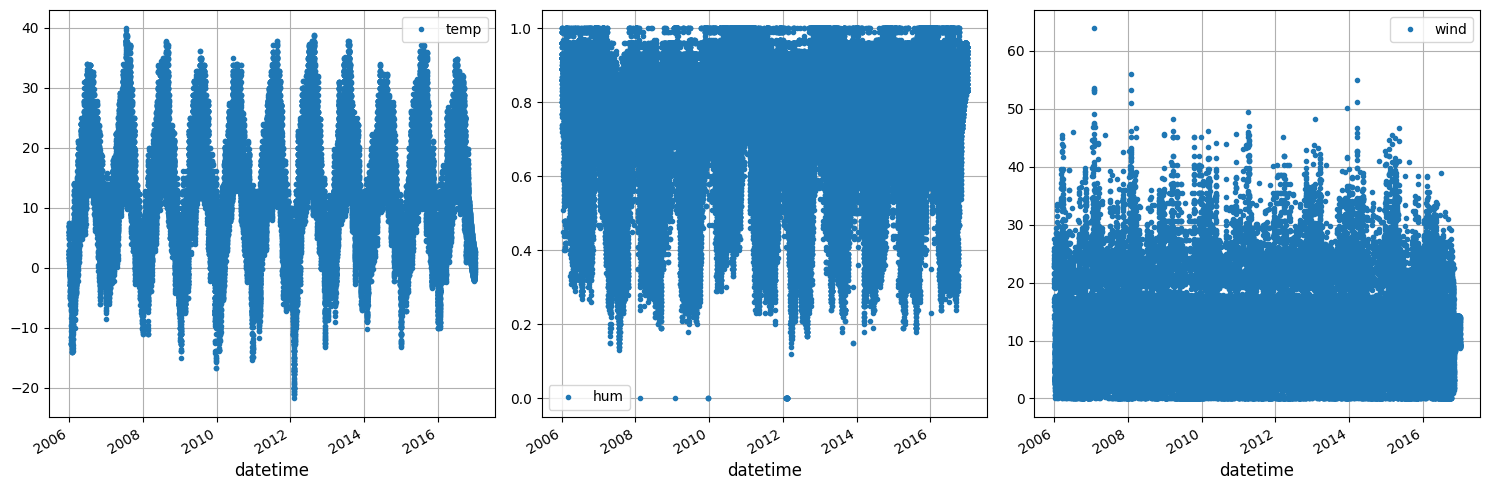

In [11]:
fig = plt.figure(figsize = (15,5))

ax = fig.add_subplot(1, 3, 1)
tmp_df.plot(x='datetime', y='temp', style=".", ax = ax);
ax.grid()
ax = fig.add_subplot(1, 3, 2)
tmp_df.plot(x='datetime', y='hum', style=".", ax = ax);
ax.grid()
ax = fig.add_subplot(1, 3, 3)
tmp_df.plot(x='datetime', y='wind', style=".", ax = ax);
ax.grid()

plt.tight_layout()

In [12]:
time_step = 24

In [13]:
y_idx = np.arange(time_step, tmp_df.shape[0], time_step)
y_df = tmp_df.iloc[y_idx][['datetime','temp']]
y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [14]:
tmp_df = tmp_df.iloc[range(len(y_df) * time_step)]
tmp_df

,datetime,temp,hum,wind
0,2005-12-31 23:00:00+00:00,0.577778,0.89,17.1143
1,2006-01-01 00:00:00+00:00,1.161111,0.85,16.6152
2,2006-01-01 01:00:00+00:00,1.666667,0.82,20.2538
3,2006-01-01 02:00:00+00:00,1.711111,0.82,14.4900
4,2006-01-01 03:00:00+00:00,1.183333,0.86,13.9426
...,...,...,...,...
96427,2016-12-30 21:00:00+00:00,-0.427778,0.91,9.1931
96428,2016-12-30 22:00:00+00:00,-0.638889,0.92,9.1609
96429,2016-12-30 23:00:00+00:00,-0.872222,0.94,9.1126
96430,2016-12-31 00:00:00+00:00,-1.161111,0.95,8.9999


In [15]:
tmp_df['temp'].shape, tmp_df.shape

((96432,), (96432, 4))

In [16]:
y_df.shape

(4018, 2)

In [17]:
X = tmp_df.to_numpy()

In [18]:
X[:, 1]

array([0.5777777777777773, 1.161111111111113, 1.6666666666666667, ...,
       -0.8722222222222223, -1.161111111111111, -1.4888888888888887],
      dtype=object)

In [19]:
X_temp = np.reshape(tmp_df['temp'].values, (y_df.shape[0], time_step))
X_hum = np.reshape(tmp_df['hum'].values, (y_df.shape[0], time_step))
X_wind = np.reshape(tmp_df['wind'].values, (y_df.shape[0], time_step))
X_temp.shape

(4018, 24)

In [20]:
X_temp = X_temp[:, :23]
X_hum = X_hum[:, :23]
X_wind = X_wind[:, :23]
X_wind.shape

(4018, 23)

## Note

Need to reshape the inputs into the 3D format as expected by the SimpleRNNs, namely [samples, timesteps, features].

In [21]:
X_data = np.stack((X_temp, X_hum), axis = 2)
X_data = np.reshape(X_data, (X_temp.shape[0], X_temp.shape[1], 2)) # Samples, timesteps, features
X_data.shape

(4018, 23, 2)

In [22]:
split = int(y_df.shape[0] * (1-TEST_SIZE))
X_train = X_data[:split]
X_test = X_data[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3214, 23, 2), (804, 23, 2), (3214,), (804,))

In [23]:
h_units = 256 # number of units in the RNN
input_shape=(time_step-1, X_train.shape[2] ) # we are using two features
kernel_initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=input_shape))

model.add(tf.keras.layers.SimpleRNN(units = h_units,
                                    kernel_initializer=kernel_initializer,
                                    activation = 'tanh'))

model.add(tf.keras.layers.Dense(1, 
                                kernel_initializer=kernel_initializer,
                                activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

I0000 00:00:1721468493.802856   90447 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721468493.807330   90447 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721468493.811153   90447 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721468493.972902   90447 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 256)            │        66,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,561 (260.00 KB)

 Trainable params: 66,561 (260.00 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    batch_size= BATCH_SIZE, 
                    verbose=1)

Epoch 1/30


I0000 00:00:1721468494.798736   90529 service.cc:146] XLA service 0x77fe40005310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721468494.798768   90529 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-20 15:11:34.821273: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-20 15:11:34.930452: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


 42/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8009 - root_mean_squared_error: 1.6391

I0000 00:00:1721468495.248646   90529 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0638 - root_mean_squared_error: 1.4065 - val_loss: 0.7687 - val_root_mean_squared_error: 0.8768
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2070 - root_mean_squared_error: 1.0977 - val_loss: 0.7382 - val_root_mean_squared_error: 0.8592
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2005 - root_mean_squared_error: 1.0948 - val_loss: 0.7470 - val_root_mean_squared_error: 0.8643
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1813 - root_mean_squared_error: 1.0856 - val_loss: 0.7055 - val_root_mean_squared_error: 0.8399
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1756 - root_mean_squared_error: 1.0830 - val_loss: 0.7076 - val_root_mean_squared_error: 0.8412
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1967 - root_mean_squared_error: 1.0929 - val_loss: 0.7080 - val_root_mean_squared_error: 0.8414
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.

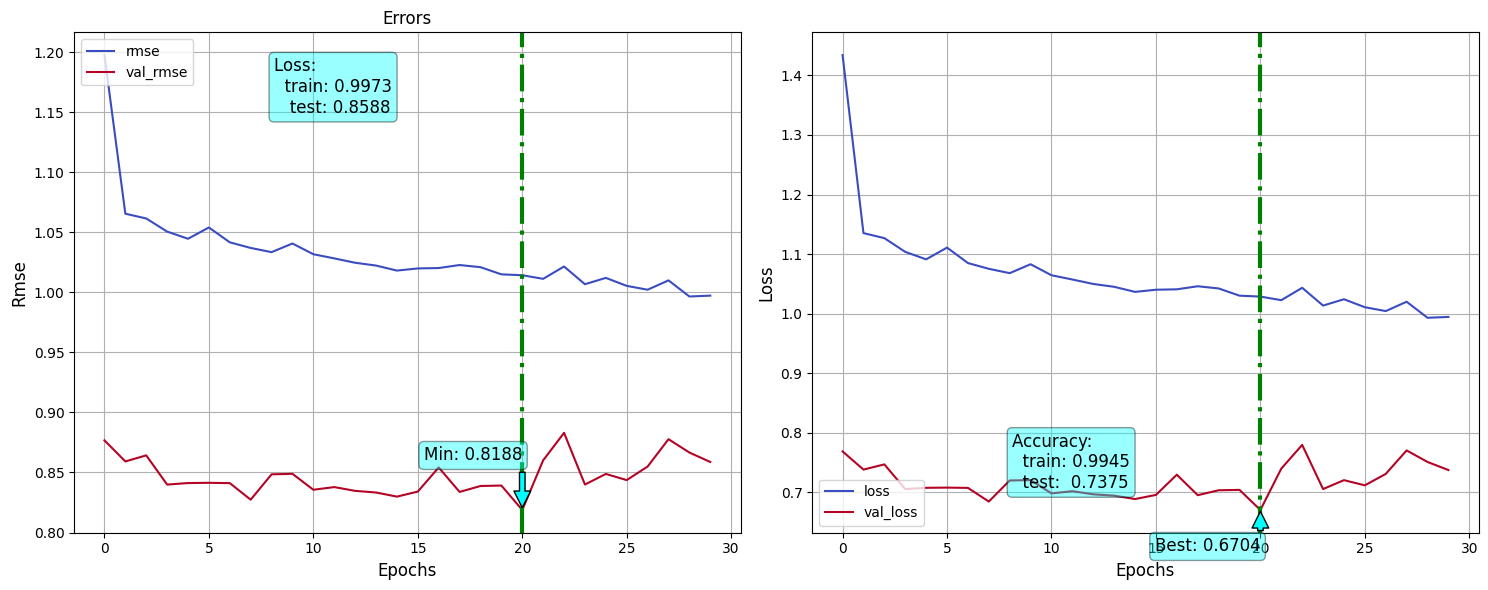

In [26]:
hist_df = pd.DataFrame(history.history)
hist_df = hist_df.rename({'root_mean_squared_error': 'rmse', 'val_root_mean_squared_error' : 'val_rmse'}, axis=1)


fn_plot_tf_hist(hist_df)
#.8172

In [27]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred, y_test_pred)

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [28]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.422222,4.902134
48,2006-01-02,1.694444,1.697676
72,2006-01-03,2.200000,2.056695
96,2006-01-04,1.666667,1.881010
120,2006-01-05,1.805556,2.294707


In [29]:
res_df.tail()

,datetime,temp,pred
96336,2016-12-27,-1.627778,-1.187305
96360,2016-12-28,-1.677778,-1.233181
96384,2016-12-29,-1.727778,-1.278855
96408,2016-12-30,-1.777778,-1.324817
96432,2016-12-31,-1.822222,-1.362441


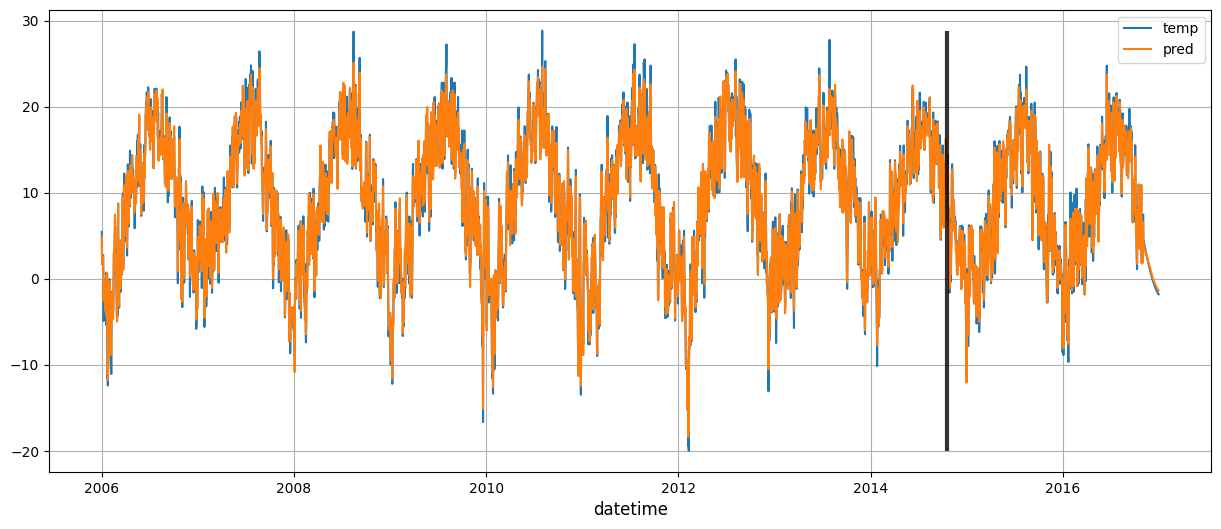

In [30]:
fig, ax = plt.subplots(figsize = (15,6))

res_df.plot(x='datetime', y=['temp','pred'], ax = ax);

ax.vlines(res_df.iloc[X_train.shape[0]]['datetime'], 
          res_df['temp'].min(), 
          res_df['temp'].max(), color = 'k', 
          linewidth=3.0, zorder=10, alpha =0.8)

ax.grid()